# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Latent-Semantic-Analysis" data-toc-modified-id="Latent-Semantic-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Latent Semantic Analysis</a></div><div class="lev2 toc-item"><a href="#Reference" data-toc-modified-id="Reference-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Reference</a></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

%watermark -a 'Ethen' -d -t -v -p numpy,scipy,pandas,matplotlib,sklearn

Ethen 2017-11-28 07:34:15 

CPython 3.5.2
IPython 6.2.1

numpy 1.13.3
scipy 1.0.0
pandas 0.20.3
matplotlib 2.1.0
sklearn 0.19.1


# Latent Semantic Analysis

We'll start by converting the raw documents into tfidf feature representation.

http://scikit-learn.org/stable/auto_examples/text/document_clustering.html#sphx-glr-auto-examples-text-document-clustering-py

In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space']

dataset = fetch_20newsgroups(
    subset = 'all', categories = categories,
    shuffle = True, random_state = 42)

X = dataset.data
y = dataset.target

In [3]:
tfidf = TfidfVectorizer(
    max_df = 0.5, min_df = 2, stop_words = 'english')

svd = TruncatedSVD(n_components = 100)
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('svd', svd)])
X_svd = pipeline.fit_transform(X)
X_svd

array([[ 0.13790297,  0.04587822,  0.0076518 , ...,  0.00311818,
        -0.01427982,  0.02456973],
       [ 0.10070367, -0.04264189,  0.01106902, ..., -0.03418022,
         0.0046775 ,  0.02264538],
       [ 0.06280476, -0.04530385,  0.00501214, ..., -0.00493659,
        -0.00138686,  0.01472249],
       ..., 
       [ 0.13546706, -0.12772737, -0.01815986, ..., -0.07288574,
         0.00215883,  0.03932414],
       [ 0.10823456, -0.02640771,  0.00563292, ..., -0.00561266,
         0.00380719,  0.00337638],
       [ 0.1112168 , -0.08240669,  0.00732457, ..., -0.00355186,
        -0.03169318,  0.05187393]])

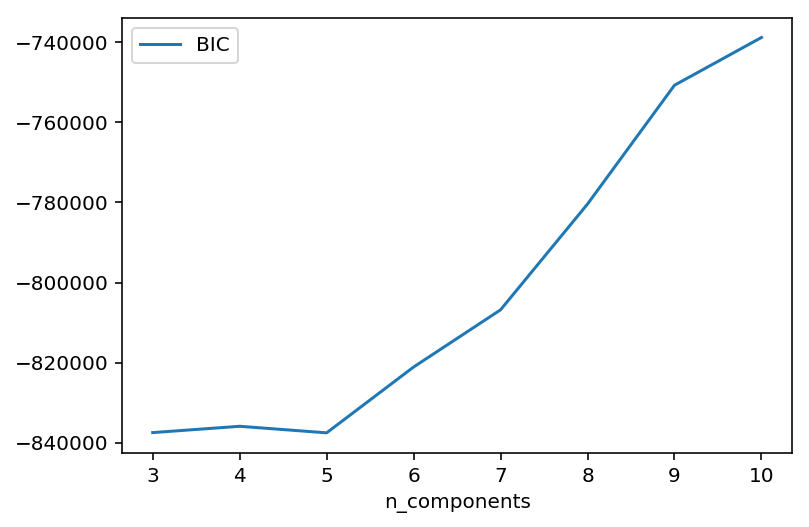

In [4]:
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture


# loop through each number of Gaussians compute the BIC, and save the model
# https://stackoverflow.com/questions/39920862/model-selection-for-gaussianmixture-by-using-gridsearch
models = []
n_components_range = np.arange(3, 11)
bic = np.zeros(n_components_range.size)
normed_factors = normalize(X_svd)

for i, n_components in enumerate(n_components_range):
    # mixture model can be sensitive to the initialized centroids,
    # since the item embedding is not that large, we can run it
    # for more than 1 time (n_init) to ensure consistency
    gmm = GaussianMixture(n_components = n_components, n_init = 3)
    gmm.fit(normed_factors)
    bic[i] = gmm.bic(normed_factors)
    
    # we can probably just save the best model (best as in the model
    # with the lowest BIC), but we'll store all of them for now; in
    # case the "best" model doesn't give enough interpretabilitys
    models.append(gmm)


plt.plot(n_components_range, bic, label = 'BIC')
plt.xlabel('n_components')
plt.legend()
plt.show()

In [5]:
gmm = models[1]
gmm.means_.shape

(4, 100)

In [6]:
count = 5
scores = gmm.means_[0, :]

ids = np.argpartition(scores, -count)[-count:]
best_ids = np.argsort(scores[ids])[::-1]
best = ids[best_ids]
best

array([ 0,  1, 15,  7,  5])

In [7]:
scores = gmm.means_

n_row = scores.shape[0]
row = np.repeat(np.arange(n_row), count)
ids = np.argpartition(scores, -count, axis = 1)[:, -count:]
sliced = scores[row, ids.ravel()].reshape(n_row, -1)
best_ids = np.argsort(sliced, axis = 1)[:, ::-1]
best = ids[row, best_ids.ravel()].reshape(n_row, -1)
best

array([[ 0,  1, 15,  7,  5],
       [ 0,  1,  2, 11, 16],
       [ 0,  4,  6, 33, 24],
       [ 0,  3,  5, 20,  7]])

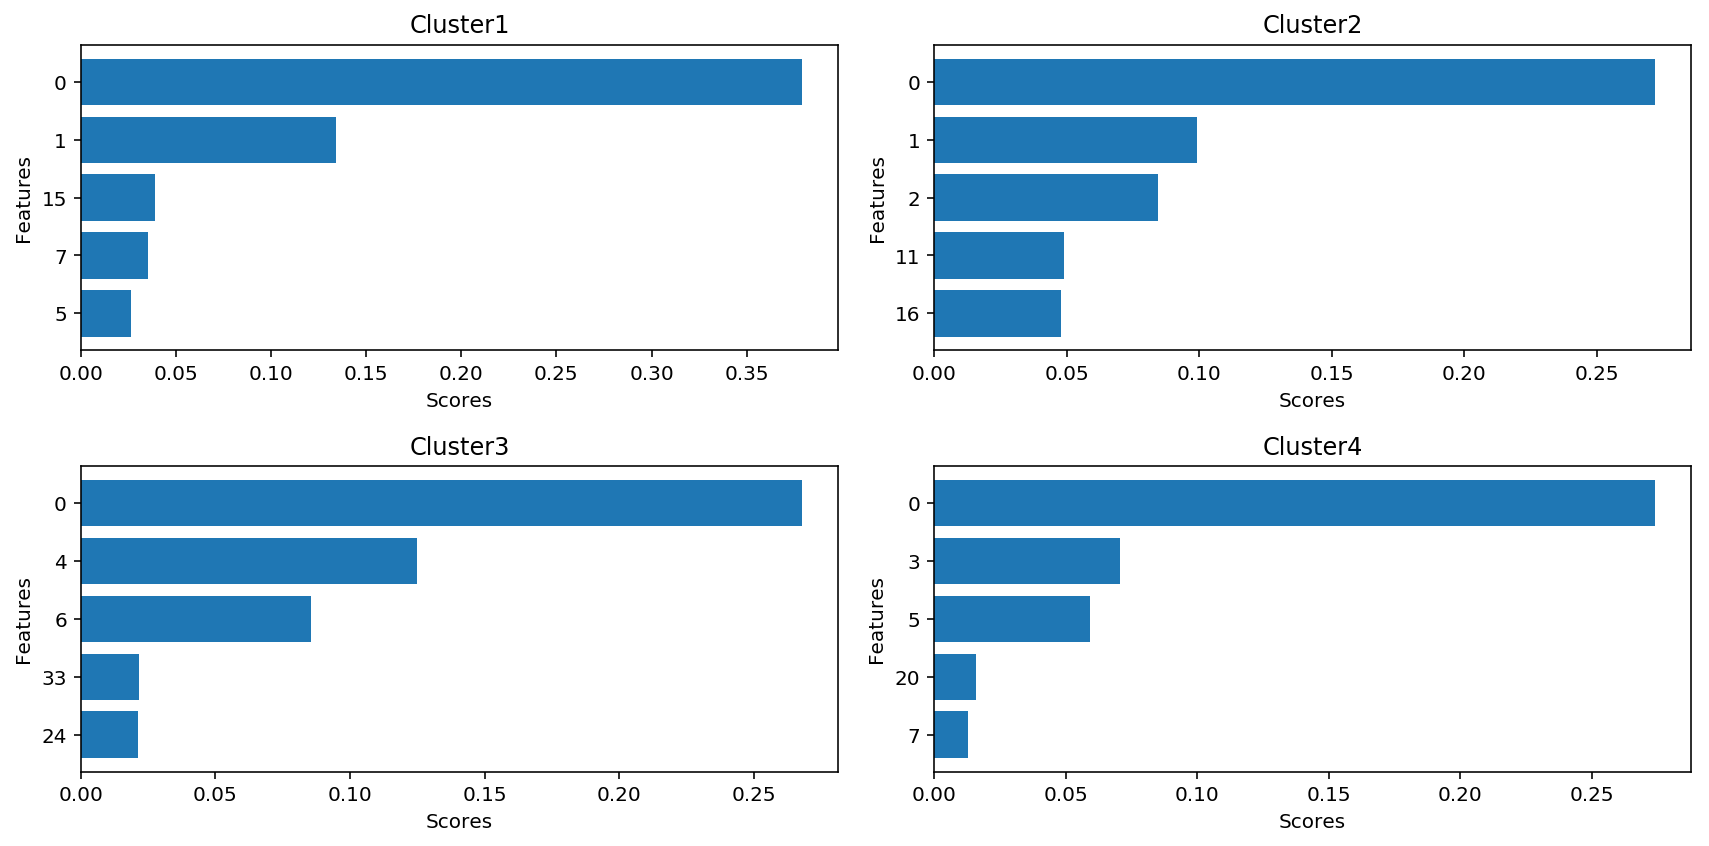

In [14]:
plt.rcParams['figure.figsize'] = 12, 6

import math

def vis_top_cluster_weight(scores, topn):
    size = math.sqrt(scores.shape[0])
    n_col = math.ceil(size)
    n_row = int(size)
    fig = plt.figure()

    for idx, score in enumerate(scores):
        # obtain the topn feature weight
        ids = np.argpartition(score, -topn)[-topn:]
        best_ids = np.argsort(score[ids])
        best = ids[best_ids]

        yticks = np.arange(1, best.size + 1)
        ax = plt.subplot(n_row, n_col, idx + 1)
        ax.barh(yticks, score[best])
        ax.set_yticks(yticks)
        ax.set_yticklabels(best)
        ax.set_xlabel('Scores')
        ax.set_ylabel('Features')
        ax.set_title('Cluster' + str(idx + 1))

    plt.tight_layout()

vis_top_cluster_weight(scores = gmm.means_, topn = 5)
plt.show()

In [10]:
# from sklearn.cluster import KMeans

# kmeans = KMeans(
#     n_clusters = len(categories), max_iter = 100)
# kmeans.fit(X_svd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
gmm.means_.shape

(10, 100)

In [21]:
centroids = svd.inverse_transform(kmeans.cluster_centers_)
centroids.shape

(4, 24545)

In [26]:
centroids = svd.inverse_transform(kmeans.cluster_centers_)
centroids_ordered = centroids.argsort()[:, ::-1]

terms = tfidf.get_feature_names()
for i in range(len(categories)):
    print("Cluster {}:".format(i), end = '')
    for ind in centroids_ordered[i, :10]:
        print(' {}'.format(terms[ind]), end = '')

    print()

Cluster 0: space henry nasa toronto access gov digex alaska pat shuttle
Cluster 1: god com sandvik people kent sgi jesus keith apple don
Cluster 2: god com sandvik people don article jesus sgi think say
Cluster 3: space com nasa henry access toronto article like just don


In [5]:
example = [
    'Machine learning is super fun',
    'Python is super, super cool',
    'Statistics is cool, too',
    'Data science is fun',
    'Python is great for machine learning',
    'I like football',
    'Football is great to watch'
]
tfidf = TfidfVectorizer(stop_words = 'english')
example_tfidf = tfidf.fit_transform(example)
print(example_tfidf.shape)

(7, 13)


Now that we converted the raw documents to tfidf feature representation, we then project the tfidf vectors onto the first N ( `n_components` is a hyperparameter that we have to select) principal components. Although the feature's dimensionality is now significantly fewer than the original tfidf vector, they are considered to be more representative features. After reducing the dimensionality, we'll once again perform a normalization to scale the features to unit norms.

In [24]:
# truncated SVD works on term count/tf-idf matrices,
# it is also known as latent semantic analysis (LSA)
svd = TruncatedSVD(n_components = 2, n_iter = 15)
lsa = Pipeline([ ('svd', svd), ('normalize', Normalizer(copy = False)) ])
example_tfidf_lsa = lsa.fit_transform(example_tfidf)
print( 'total variance explained:', np.sum(svd.explained_variance_) )

# document - component
pd.DataFrame( example_tfidf_lsa, index = example, columns = ['component_1', 'component_2'] )

total variance explained: 0.252606886963


,component_1,component_2
Machine learning is super fun,0.971405,-0.237427
"Python is super, super cool",0.916936,-0.399033
"Statistics is cool, too",0.711164,-0.703026
Data science is fun,0.874284,-0.485415
Python is great for machine learning,0.980306,0.197485
I like football,0.155955,0.987764
Football is great to watch,0.337600,0.941290


As we can see, performing LSA on the original document, the dimensionality of the feature has decreased from 13 to 2. Now, each document is a linear combination of the two LSA components (as shown above), while each LSA component is a linear combination of words (as shown below).

In [7]:
# component - word
vocab = tfidf.get_feature_names()
pd.DataFrame( svd.components_, index = ['component_1', 'component_2'], columns = vocab )

,cool,data,football,fun,great,learning,like,machine,python,science,statistics,super,watch
component_1,0.211903,0.082524,0.123490,0.293206,0.283966,0.425531,0.048611,0.425531,0.343490,0.082524,0.083414,0.510029,0.100157
component_2,-0.175362,-0.061554,0.654756,-0.124878,0.365768,-0.019431,0.413619,-0.019431,-0.029054,-0.061554,-0.110779,-0.240595,0.375162


Since we now only have 2 features, we can also visualize each document's vector. The geometric interpretation is: two similar documents will point toward simliar direction, in other words, the two vector that represent the document will have smaller angle in between.

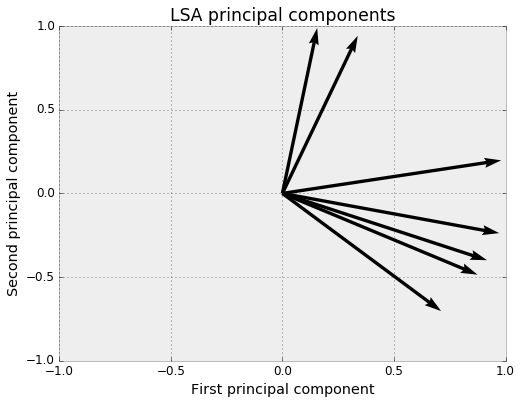

In [8]:
# plot the principal components (use quiver for vector fields)
x = example_tfidf_lsa[:, 0]
y = example_tfidf_lsa[:, 1]

fig, ax = plt.subplots(1, 1)
ax.quiver(0, 0, x, y, angles = 'xy', scale_units = 'xy',scale = 1, linewidth = .01)
ax.set_xlim([ -1, 1 ])
ax.set_ylim([ -1, 1 ])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('LSA principal components')
fig.show()

In [3]:
import pickle

FILEPATH = os.path.join('data', 'raw_text_dataset.pickle')
raw_text_dataset = pickle.load( open( FILEPATH, 'rb' ) )
X_train_raw = raw_text_dataset[0]
y_train_labels = raw_text_dataset[1] 
X_test_raw = raw_text_dataset[2]
y_test_labels = raw_text_dataset[3]

In [5]:
# convert raw documents to tfidf feature representation;
# - strips out a list of english stop words;
# - filters out terms that occur in more than half of the docs (max_df=0.5)
# - filters out terms that occur in only one document (min_df=2).
# - selects the 10,000 most frequently occuring words in the corpus
tfidf = TfidfVectorizer(max_df = 0.5, max_features = 10000,
                        min_df = 2, stop_words = 'english')

X_train_tfidf = tfidf.fit_transform(X_train_raw)
print(X_train_tfidf.shape)

(4743, 10000)


In [6]:
# truncated SVD works on term count/tf-idf matrices,
# it is known as latent semantic analysis (LSA)
svd = TruncatedSVD(n_components = 100, n_iter = 15)
lsa = Pipeline([ ('svd', svd), ('normalize', Normalizer(copy = False)) ])

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
print(X_train_lsa.shape)

(4743, 100)


In [7]:
svd.components_

array([[  5.16868641e-03,   2.67730482e-01,   2.19358567e-03, ...,
          1.35045340e-04,   2.48934912e-04,   7.16342505e-04],
       [  8.76705946e-03,  -2.05275420e-02,  -5.15322100e-04, ...,
          1.02237316e-03,   1.45021891e-03,   1.04164490e-03],
       [ -7.74525340e-04,  -1.63326764e-01,  -1.90116397e-03, ...,
          6.46334096e-06,  -8.38084994e-05,  -3.44853310e-04],
       ..., 
       [ -2.84988780e-02,   2.07451923e-02,  -2.64614386e-03, ...,
         -1.14197704e-04,  -3.29929132e-04,   3.02162073e-03],
       [ -8.07440365e-03,  -4.29738351e-03,   1.62529037e-03, ...,
         -6.51882533e-04,   1.52160756e-04,  -1.95796930e-03],
       [  4.16584569e-03,   7.71004739e-03,  -8.86060082e-03, ...,
         -3.41306856e-04,  -5.86801350e-05,   1.52078076e-03]])

In [46]:
lsa.named_steps['svd'].components_.shape

(100, 10000)

In [36]:
lsa.explained_variance_ratio_

array([ 0.03204465,  0.01094008,  0.01495829,  0.00791216,  0.00659883,
        0.00630385,  0.00625253,  0.00564834,  0.0048622 ,  0.0045222 ,
        0.0045885 ,  0.00409799,  0.00381508,  0.00313612,  0.00262854,
        0.00232603,  0.00215106,  0.00200291,  0.00192625,  0.00186778,
        0.00179161,  0.00164662,  0.00158817,  0.00147094,  0.00143266,
        0.00140267,  0.00124479,  0.00122631,  0.00120548,  0.00116956,
        0.00112467,  0.00108339,  0.00105352,  0.00101777,  0.00099316,
        0.00096049,  0.00094521,  0.00093184,  0.00091132,  0.00089602,
        0.00088391,  0.00085753,  0.00085188,  0.00082159,  0.00080896,
        0.00079958,  0.00077914,  0.00076902,  0.00076393,  0.00075293,
        0.00074145,  0.00072395,  0.00070824,  0.00069893,  0.00069274,
        0.00067801,  0.00066727,  0.00065434,  0.00064619,  0.00064026,
        0.00063137,  0.00062124,  0.00061347,  0.00059923,  0.00058311,
        0.00057426,  0.00055699,  0.00055297,  0.00054891,  0.00

In [34]:
lsa.components_.shape

(100, 10000)

In [ ]:
for compNum in range(0, 10):

    comp = svd.components_[compNum]
    
    # Sort the weights in the first component, and get the indeces
    indeces = numpy.argsort(comp).tolist()
    
    # Reverse the indeces, so we have the largest weights first.
    indeces.reverse()
    
    # Grab the top 10 terms which have the highest weight in this component.        
    terms = [feat_names[weightIndex] for weightIndex in indeces[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indeces[0:10]]    
    
    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = arange(10) + .5    # the bar centers on the y axis
    
    figure(compNum)
    barh(positions, weights, align='center')
    yticks(positions, terms)
    xlabel('Weight')
    title('Strongest terms for component %d' % (compNum))
    grid(True)
    show()

## Reference

- [Notes: Latent Semantic Analysis](http://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf)